# INM705 - Deep Learning for Image Analysis

Authors: Laerte Adami - Alperen Erol

In [1]:
#from torchvision.models import vgg16
# https://github.com/pochih/FCN-pytorch/blob/master/python/fcn.py

In [2]:
#from Utilities.UNET.unetModel import UnetGenerator as Unet

In [3]:
from Utilities.FCN.myFcn import my_fcn_resnet50

#FCN_weights = FCN_ResNet50_Weights.DEFAULT
#backbone_weights = ResNet50_Weights.DEFAULT
#mymodel = my_fcn_resnet50(backbone_weights=backbone_weights).to(device)

In [4]:
# https://github.com/goldbattle/pytorch_unet/blob/master/datasets.py

# Custom functionalities
from Utilities.classHandler import CityscapesClass
from Utilities.datasetHandler import CityscapesDataset, visualise_and_save
from Utilities.modelHandler import modelFCN, modelUNet
from Utilities.metrics import meanPixelwiseAccuracy, meanIoU
#from Utilities.unet import UNet
from Utilities.customLoss import DiceLoss

import os
import time
import torch
import torch.nn.functional as F
from torchvision.io.image import read_image
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import DataLoader
from torch import nn
from torchvision.models import ResNet50_Weights
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torchvision.utils import draw_segmentation_masks
import matplotlib.pyplot as plt

device = torch.device('cpu')
if torch.cuda.is_available(): device = torch.device('cuda')

torch.cuda.empty_cache()

#plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 17

## Data

In [5]:
### DATASET ###
classes = CityscapesClass("4 classes") # Pick a case: "4 classes", "6 classes", "10 classes"

img_directory = '/mnt/data/course/psarin/inm705/leftImg8bit'
ground_truth_directory = '/mnt/data/course/psarin/inm705/gtFine_trainvaltest/gtFine'
n_classes = len(classes.labels) 
resize_dimensions = (128, 256)#(205,410)

dataset_args = {'image_directory' : img_directory,
                'gt_directory' : ground_truth_directory,
                'trainId' : classes.trainId,
                'colors' : classes.colors,
                'num_classes' : n_classes,
                'resize_dimensions' : resize_dimensions}

# Import datasets
dt_train = CityscapesDataset(phase = 'train', **dataset_args)

dt_val = CityscapesDataset(phase = 'val', **dataset_args)

dt_test = CityscapesDataset(phase = 'test', **dataset_args)

# Initialise dataloaders
dataloader_args = {'batch_size':32, 'shuffle':True}

## TRAIN dataset
trainloader = DataLoader(dt_train, **dataloader_args)
## VAL dataset
valloader = DataLoader(dt_val, batch_size = 32)  
## TEST dataset
testloader = DataLoader(dt_test, batch_size=10)  

print("Training set dimension: {}".format(dt_train.__len__()))

Training set dimension: 174


- Aggiungi un layer
- Togli un layer
- Prova diversi features extractor
- prova diversi loss
- Valuta la accuracy per class

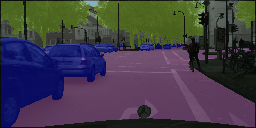

In [6]:
# Check dataset
X_viz, X_viz_norm = dt_train.get_image_visualization(10)
gt_mask = dt_train.get_ground_truth(10)
gt_mask = gt_mask.argmax(dim=0)

bool_masks = gt_mask == torch.arange(n_classes)[:, None, None]

sm = draw_segmentation_masks(X_viz, masks=bool_masks, alpha=0.6, colors = dt_train.colors)
to_pil_image(sm)

## Model

In [10]:
## INITIALISE EXPERIMENT ##
exp_name = "fcn_res_part_4clas"

## Models paramaters
total_epochs      = 30
save_every_epochs = 6 
learning_rate     = 1e-3
w_decay           = 1e-3

## Create results directory
results_path = os.path.join("Results/", exp_name)
checkpoint_path = os.path.join("Checkpoints/", exp_name)

if not os.path.isdir(results_path):
    os.mkdir(results_path)
    os.mkdir(checkpoint_path)
else:
    os.mkdir(results_path+"_v2")
    os.mkdir(checkpoint_path+"_v2")

### FCN

In [12]:
##MODEL Pretrained with RESNET 50
#Initialize model with the best available weights
FCN_weights = FCN_ResNet50_Weights.DEFAULT
backbone_weights = ResNet50_Weights.DEFAULT
model = my_fcn_resnet50(backbone_weights=backbone_weights).to(device)
#model = my_fcn_resnet50().to(device)

model.backbone.requires_grad_(True)
model.classifier[4] = nn.Conv2d(512, n_classes, kernel_size=(1, 1), stride=(1, 1))
model.classifier.requires_grad_(True)

cel = CrossEntropyLoss()
ad = Adam(model.parameters(), lr = learning_rate, weight_decay = w_decay)

fcn1 = modelFCN(model, loss_function=cel, optimizer = ad )
fcn1.model.to(device);

### U-Net

##MODEL
#model = UNet(enc_chs=(3,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=n_classes, retain_dim=True, out_sz=resize_dimensions)
model = Unet(3, n_classes, 64)
#model = model.to(device)

cel = CrossEntropyLoss()
dl = DiceLoss()
ad = Adam(model.parameters(), lr = learning_rate, weight_decay = w_decay)

fcn1 = modelUNet(model, loss_function=cel, optimizer = ad)
fcn1.model.to(device);

## Training

Completed epoch 1
Computational time required: 0.0 h


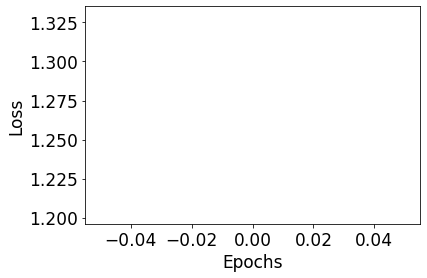

In [13]:
## TRAINING PHASE ##
start_time = time.time()

L, ckp_list  = fcn1.train_model(trainloader, total_epochs=total_epochs, save_every_epochs = save_every_epochs, ckp_name = checkpoint_path+"/"+exp_name)

comp_time = time.time() - start_time
print("Computational time required: {} h".format(round(comp_time / 3600,0)))

fig, ax = plt.subplots()
ax.plot(L, linewidth = 3)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss");
plt.savefig(results_path+"/training_loss.png")

## Model validation

In [20]:
# Load checkpoint
#fcn1.model.load_state_dict(torch.load("Checkpoints/fcn_28_02_10classes_12.pth"))
#fcn1.model.eval();

# Step 4: Use the model and visualize the prediction
#_, X_test, y_test = next(iter(valloader))
#X_test, y_test = X_test.to(device), y_test.to(device) 

#fcn1.model.to(device)
#pred = fcn1.model(X_test)['out'] #METTILO PER FCN

# Apply softmax and threshold value
#out = F.softmax(pred,dim=1)# > 0.5

#out = torch.argmax(out, dim=1)

#print("Output dimension: {}".format(out.size()))

In [21]:
# Computing metrics
#mPA, PAk = meanPixelwiseAccuracy(out, y_test)
#print("Mean Pixelwise Accuracy: {}".format(round(mPA,2)))

#print("Mean IoU: {}".format(round(meanIoU(out, y_test),3)))

## Model evaluation and visualisation

ckp_list = []
ckp_list.append("Checkpoints/fcn_28_02_10classes_6.pth")
ckp_list.append("Checkpoints/fcn_28_02_10classes_12.pth")
ckp_list.append("Checkpoints/fcn_28_02_10classes_18.pth")
ckp_list.append("Checkpoints/fcn_28_02_10classes_24.pth")
ckp_list.append("Checkpoints/fcn_28_02_10classes_30.pth")

In [9]:
ckp_list

['Checkpoints/fcn_28_02_10classes_6.pth',
 'Checkpoints/fcn_28_02_10classes_12.pth',
 'Checkpoints/fcn_28_02_10classes_18.pth',
 'Checkpoints/fcn_28_02_10classes_24.pth',
 'Checkpoints/fcn_28_02_10classes_30.pth']

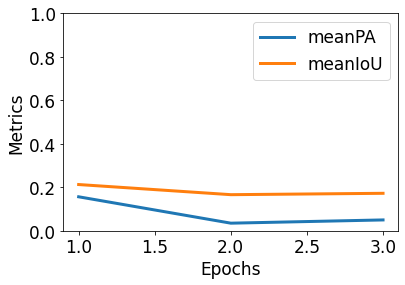

In [15]:
image_id = 20

# Create variables to store progressive results
grid_list = []
e_list    = []
acc_list  = []
iou_list  = []

for ckp in ckp_list:
    
    # Extract the epoch number
    e = int(ckp.split('_')[-1].split('.pth')[0])
    e_list.append(e)
    
    # Metrics computation
    mPA, PAk, mIoU, IoUk = fcn1.evaluate_model(next(iter(valloader)), ckp)
    acc_list.append(mPA)
    iou_list.append(mIoU)
    
    # Results visualisation
    grid = visualise_and_save(ckp, fcn1, dt_val, image_id = image_id, save_name = results_path + "/id{}_ep{}.png".format(image_id,e))
    grid_list.append(grid)

# Plot accuracy and meanIoU over epochs
fig, ax = plt.subplots()
ax.plot(e_list, acc_list , linewidth = 3, label = 'meanPA')
ax.plot(e_list, iou_list , linewidth = 3, label = 'meanIoU')
ax.set_xlabel("Epochs")
ax.set_ylabel("Metrics")
ax.set_ylim(0,1)
plt.legend()
plt.savefig(results_path+"/mPA_epochs.png")

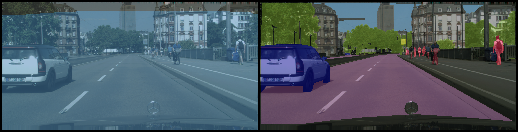

In [16]:
to_pil_image(grid_list[-1])

## Old visualization

n_test = 8

X_viz, X_viz_norm = dt_val.get_image_visualization(n_test)
gt_viz = dt_val.get_ground_truth(n_test)
gt_viz = gt_viz.argmax(dim=0)

#Process the input with the model
pred_viz = fcn1.model(X_viz_norm.unsqueeze(0).to(device))['out'] #METTILO PER FCN
print(pred_viz.size())
out_viz = F.softmax(pred_viz,dim=1)# > 0.5
#Create the mask with argmax
mask = torch.argmax(out_viz, dim=1)

#Single class visualisation
class_id = 4
single_class_mask = (mask == class_id)

sm = draw_segmentation_masks(X_viz, masks=single_class_mask, alpha=0.7, colors = ( 81,  0, 81))
to_pil_image(sm)

## Check the model

from Utilities.torchsummaryNew import summary

#device = torch.device('cuda')

#model.to(device);
#model = Unet(3, 10, 64).to(device)
#model = fcn_resnet50().to(device)
model = vgg16().to(device)

summary(model, (3, 128, 256))
#summary(mymodel, (3, 128, 256))

vgg_backbone = model.features

vgg_net.to(device)
summary(vgg_net, (3, 128, 256))

fcn = my_fcn_resnet50()

vgg_net = nn.Sequential(vgg_backbone, fcn_classifier)

fcn_classifier = fcn.classifier

fcn_classifier[0] = nn.Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
fcn_classifier[1] = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
fcn_classifier[4] = nn.Conv2d(256, n_classes, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

fcn_classifier

vgg_net

fcn = fcn.to(device)

summary(fcn, (3, 128, 256))